# Toy Example

In [1]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
mean = (0.35, 0.75)
cov = [[0.05, 0], [0, 0.05]]
X_l = np.random.multivariate_normal(mean, cov, (1000))

uncontrained_ids = np.where((X_l<0).astype('int32') + (X_l>1).astype('int32'))[0]
X_l[uncontrained_ids] = np.random.rand(len(uncontrained_ids), 2)

In [3]:
X_u = np.random.rand(10000,2)

In [14]:
import pickle
#pickle.dump([X_l, X_u], open('data/data.p', 'wb'))
[X_l, X_u] = pickle.load(open('data/data.p', 'rb'))
X_u = X_u[:4000]

<IPython.core.display.Javascript object>


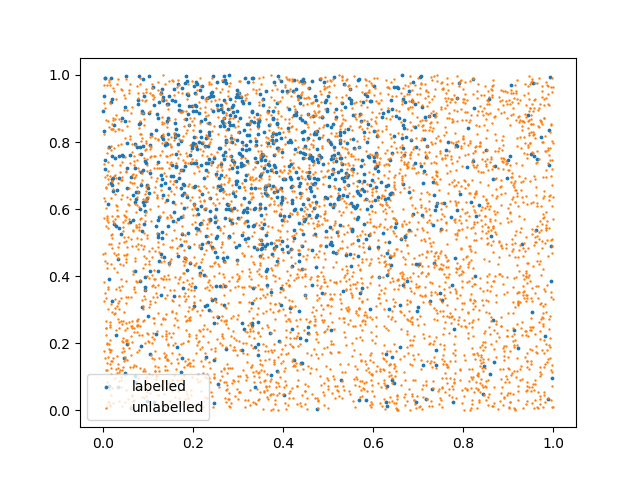

In [5]:
p = plt.scatter(X_l[:,0], X_l[:,1], s=3)
plt.scatter(X_u[:,0], X_u[:,1], s=.5)
plt.legend(['labelled', 'unlabelled'])

In [6]:
def sinc(xy):
    x = xy[:,0]-0.5
    y = xy[:, 1]-0.5
    r = np.sqrt(x**2 + y**2)
    
    ret = np.sin(40*r)/r**0.5
    ret = ret/10 + .3
    return ret

<IPython.core.display.Javascript object>


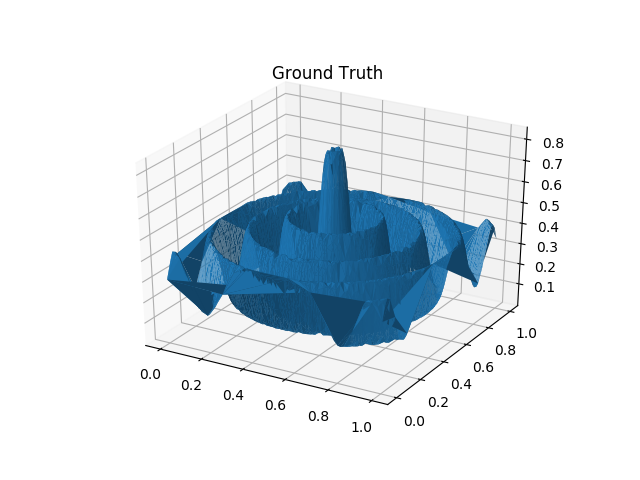

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X_u[:,0], X_u[:,1], sinc(X_u))
plt.title('Ground Truth')

<IPython.core.display.Javascript object>


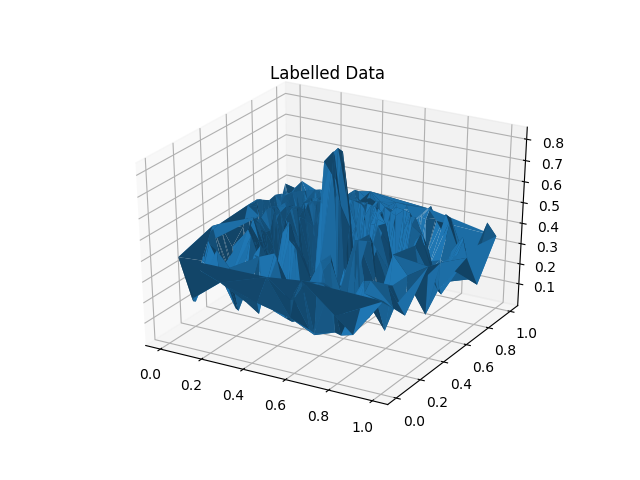

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X_l[:,0], X_l[:,1], sinc(X_l))
plt.title('Labelled Data')

In [15]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def sigmoid_inv(y):
    return np.log(y) - np.log(1-y)

In [16]:
def pts2box(X, y, bins=100):
    ret = np.zeros((bins, bins), 'float32')
    X_scaled = X * bins
    
    nums = dict()
    for i in range(len(X)):
        idx_x, idx_y = int(X_scaled[i,0]), int(X_scaled[i,1]) 
        ret[idx_x, idx_y] += y[i]
        try:
            nums[(idx_x, idx_y)] = nums[idx_x, idx_y] + 1
        except:
            nums[(idx_x, idx_y)] = 1
    
    for (i, j) in nums.keys():
        ret[i, j] /= nums[(i, j)]
        
    return ret

In [17]:
def model(x, reuse=False, name='simple'):
    l1 = tf.layers.dense(x, 100, activation=tf.nn.relu, reuse=reuse, name='%s1' %  name)
    l2 = tf.layers.dense(l1, 100, activation=tf.nn.relu, reuse=reuse, name='%s' %  name)
    l3 = tf.layers.dense(l2, 100, activation=tf.nn.relu, reuse=reuse, name='%s3' %  name)
    #l4 = tf.layers.dense(l3, 100, activation=tf.nn.relu, reuse=reuse, name='%s4' %  name)
    #l5 = tf.layers.dense(l4, 100, activation=tf.nn.relu, reuse=reuse, name='%s5' %  name)
    l6 = tf.layers.dense(l3, 1, reuse=reuse, name='%s6' %  name)
    
    return l6

In [18]:
x = tf.placeholder('float32', shape=[None, 2])
y = tf.placeholder('float32', shape=[None, 1])

h = model(x)

In [19]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=h)

a = tf.placeholder('float32', shape=[])
optim = tf.train.GradientDescentOptimizer(learning_rate=a).minimize(loss)

In [20]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [21]:
def batch(x, y, batch_size=100):
    l = len(x)
    ids_rand = np.random.permutation(np.arange(l))
    x_rand = x[ids_rand]
    y_rand = y[ids_rand]
    
    i = 0
    while True:
        idx_str = i*batch_size
        idx_end = (i+1)*batch_size
        
        if idx_end > l:
            ids_rand = np.random.permutation(np.arange(l))
            x_rand = x[ids_rand]
            y_rand = y[ids_rand]
            i = -1
        else:
            yield x_rand[idx_str:idx_end], y_rand[idx_str:idx_end].reshape(-1, 1)
        
        i += 1

In [22]:
it = batch(X_l, sigmoid(sinc(X_l)))

# Benchmark

In [26]:
#saver = tf.train.Saver()
#saver.restore(sess, 'data/benchmark.ckpt')

In [ ]:
for i in range(100000):
    batch_x, batch_y = next(it)
    _, ls = sess.run([optim, loss], feed_dict={x: batch_x, y: batch_y, a: 0.03})
    print(i, end='\r')    

In [16]:
for i in range(20000):
    batch_x, batch_y = next(it)
    _, ls = sess.run([optim, loss], feed_dict={x: batch_x, y: batch_y, a: 0.003})
    print(i, end='\r')    

In [ ]:
#saver = tf.train.Saver()
#saver.save(sess, 'data/benchmark.ckpt', write_meta_graph=False)

<IPython.core.display.Javascript object>


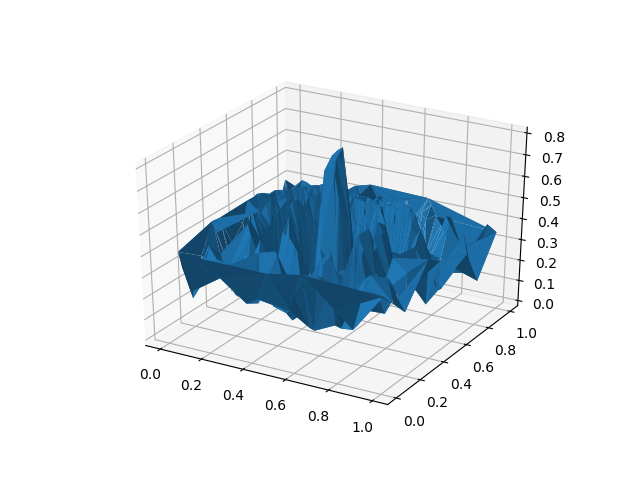

In [27]:
y_pred = sess.run(h, feed_dict={x: X_l})
y_pred = y_pred.reshape(-1)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(X_l[:,0], X_l[:,1], y_pred)

<IPython.core.display.Javascript object>


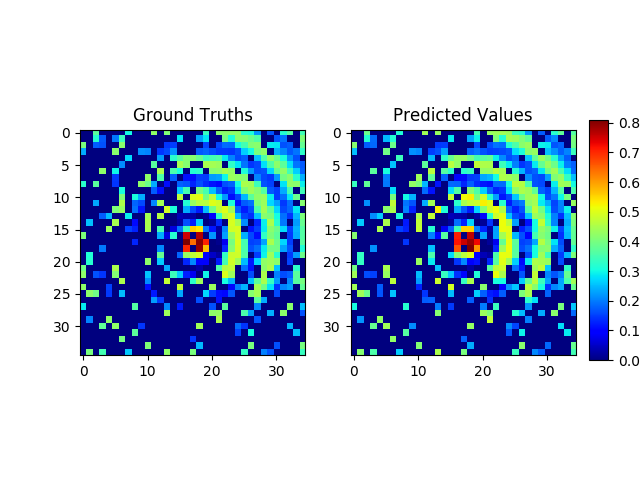

In [28]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
p0 = ax0.imshow(pts2box(X_l, sinc(X_l), 35), cmap='jet')
p1 = ax1.imshow(pts2box(X_l, y_pred, 35), cmap='jet')
cbar_ax = fig.add_axes([0.92, 0.25, 0.03, 0.50])
fig.colorbar(p1, cax=cbar_ax)

ax0.set_title('Ground Truths')
ax1.set_title('Predicted Values')

<IPython.core.display.Javascript object>


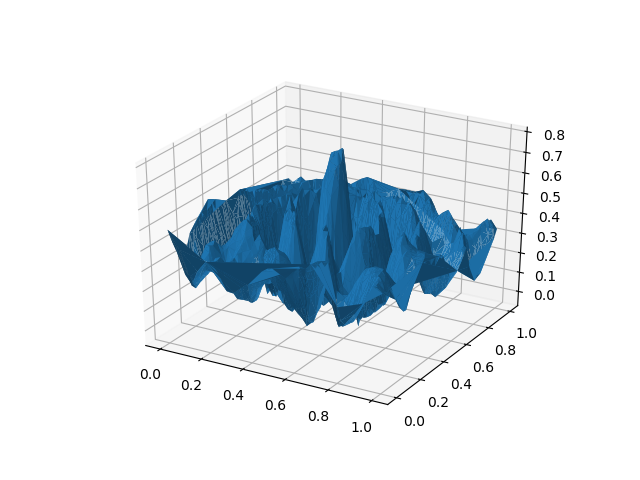

In [29]:
y_pred = sess.run(h, feed_dict={x: X_u})
y_pred = y_pred.reshape(-1)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(X_u[:,0], X_u[:,1], y_pred)

<IPython.core.display.Javascript object>


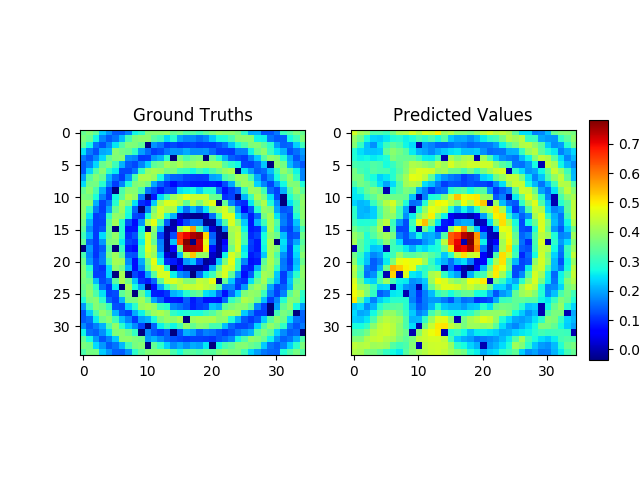

In [30]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
p0 = ax0.imshow(pts2box(X_u, sinc(X_u), 35), cmap='jet')
p1 = ax1.imshow(pts2box(X_u, y_pred, 35), cmap='jet')
cbar_ax = fig.add_axes([0.92, 0.25, 0.03, 0.50])
fig.colorbar(p1, cax=cbar_ax)

ax0.set_title('Ground Truths')
ax1.set_title('Predicted Values')

# Objective

In [31]:
it = batch(X_u, sigmoid(sinc(X_u)))

In [33]:
#saver = tf.train.Saver()
#saver.restore(sess, 'data/objective.ckpt')

INFO:tensorflow:Restoring parameters from data/objective.ckpt


In [17]:
for i in range(100000):
    batch_x, batch_y = next(it)
    _, ls = sess.run([optim, loss], feed_dict={x: batch_x, y: batch_y, a: 0.03})
    print(i, end='\r')    

In [18]:
for i in range(20000):
    batch_x, batch_y = next(it)
    _, ls = sess.run([optim, loss], feed_dict={x: batch_x, y: batch_y, a: 0.003})
    print(i, end='\r')    

In [ ]:
#saver = tf.train.Saver()
#saver.save(sess, 'data/objective.ckpt', write_meta_graph=False)

<IPython.core.display.Javascript object>


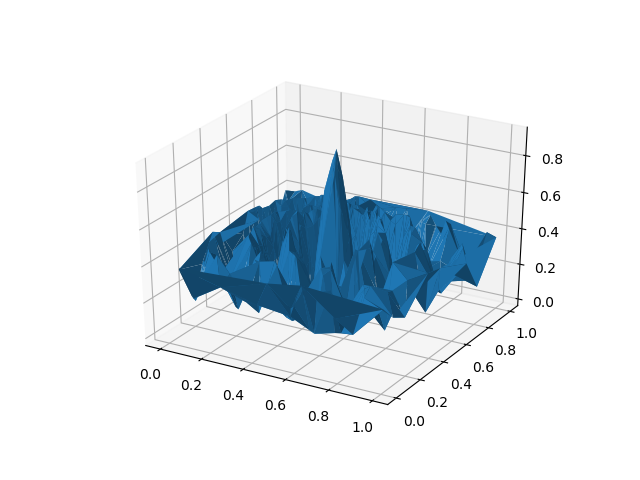

In [34]:
y_pred = sess.run(h, feed_dict={x: X_l})
y_pred = y_pred.reshape(-1)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(X_l[:,0], X_l[:,1], y_pred)

<IPython.core.display.Javascript object>


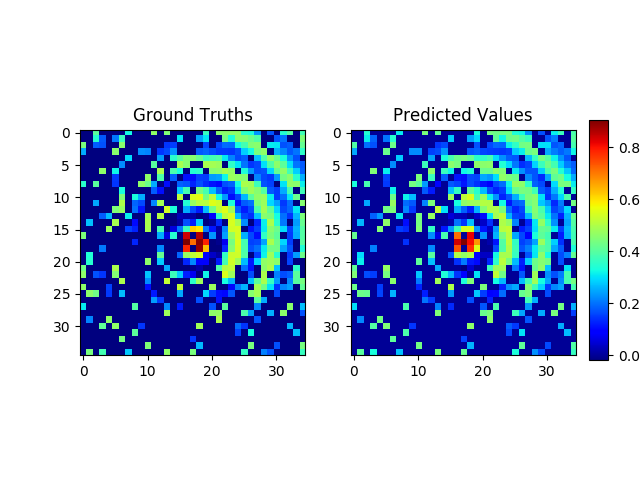

In [35]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
p0 = ax0.imshow(pts2box(X_l, sinc(X_l), 35), cmap='jet')
p1 = ax1.imshow(pts2box(X_l, y_pred, 35), cmap='jet')
cbar_ax = fig.add_axes([0.92, 0.25, 0.03, 0.50])
fig.colorbar(p1, cax=cbar_ax)

ax0.set_title('Ground Truths')
ax1.set_title('Predicted Values')

<IPython.core.display.Javascript object>


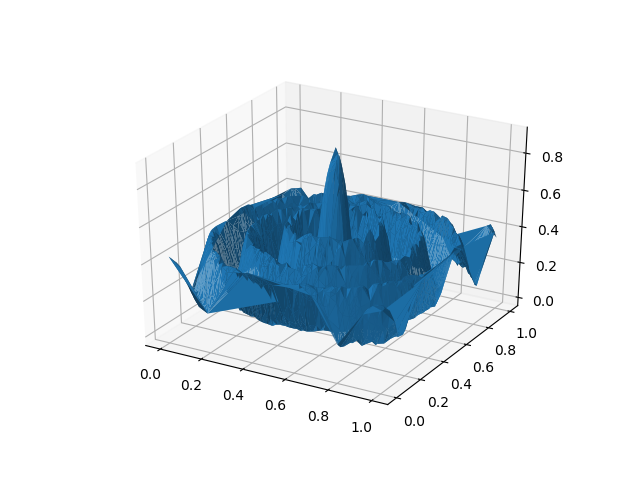

In [36]:
y_pred = sess.run(h, feed_dict={x: X_u})
y_pred = y_pred.reshape(-1)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(X_u[:,0], X_u[:,1], y_pred)

<IPython.core.display.Javascript object>


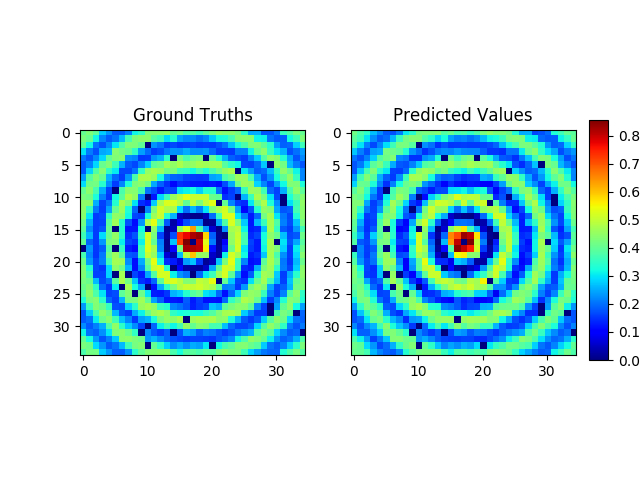

In [37]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
p0 = ax0.imshow(pts2box(X_u, sinc(X_u), 35), cmap='jet')
p1 = ax1.imshow(pts2box(X_u, y_pred, 35), cmap='jet')
cbar_ax = fig.add_axes([0.92, 0.25, 0.03, 0.50])
fig.colorbar(p1, cax=cbar_ax)

ax0.set_title('Ground Truths')
ax1.set_title('Predicted Values')

# NGM

In [40]:
#saver = tf.train.Saver()
#saver.restore(sess, 'data/ngm.ckpt')

In [41]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

In [42]:
X_tot = np.concatenate((X_l, X_u), axis=0)

In [47]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='kd_tree').fit(X_tot)
distances, indices = nbrs.kneighbors(X_tot)

#nbrs = NearestNeighbors(n_neighbors=100, algorithm='kd_tree').fit(np.sqrt(np.sum(np.square(X_tot-.5), 1)).reshape(-1,1))
#distances, indices = nbrs.kneighbors(np.sqrt(np.sum(np.square(X_tot-.5), 1)).reshape(-1,1))

In [48]:
indices = indices[:,1:]
distances = distances[:,1:]

In [49]:
l = len(X_l)
u = l + len(X_u)

In [50]:
inds = []
sims = []

for i in range(u):
    idx = []
    dist = []
    
    i_norm = (X_tot[i]-0.5) / np.sqrt(np.sum(np.square((X_tot[i]-0.5))))
    for k in range(len(indices[i])):
        j = indices[i][k]
        if i >= j:
            continue
    
        comp = X_tot[i] - X_tot[j]
        comp /= np.sqrt(np.sum(np.square(comp)))
        dist.append(np.abs(np.sum(i_norm * comp)))
        #dist.append(np.sqrt(np.sum(np.square(comp))))
    
    nb = np.argsort(dist)[:5]
    
    idx = indices[i][nb]
    dist = np.array(dist)[nb]
    sim = np.exp(-dist/1e-1)/np.sum(np.exp(-dist/1e-1))
    inds.append(idx)
    sims.append(sim)

#inds = indices
#sims = np.exp(-distances/1e-4) / np.sum(np.exp(-distances/1e-4), axis=1).reshape(-1,1)

ttt = 897
plt.figure()
plt.scatter(X_tot[ttt,0]-0.5, X_tot[ttt,1]-0.5, s=50)
plt.scatter(X_tot[inds[ttt]][:,0]-0.5, X_tot[inds[ttt]][:,1]-0.5, s =20)
plt.scatter(X_tot[ttt,0]-0.5, X_tot[ttt,1]-0.5, s=50)
r = np.sqrt(np.sum(np.square(X_tot[ttt]-0.5)))
plt.gcf().gca().add_artist(plt.Circle((0,0), r, fill=False))
plt.ylim(-r,r)
plt.xlim(-r,r)

In [52]:
graph = nx.Graph()
edges_ll = list()
edges_lu = list()
edges_uu = list()

for i in range(u):
    for k in range(len(inds[i])):
        j = indices[i][k]
        if i >= j:
            continue
            
        if (0 <= i < l) and (0 <= j < l):
            edges_ll.append((i,j))
            graph.add_edge(i, j, weight=sims[i][k])
        elif (0 <= i < l) and (l <= j < u):
            edges_lu.append((i,j))
            graph.add_edge(i, j, weight=sims[i][k])
        else:
            edges_uu.append((i,j))
            graph.add_edge(i, j, weight=sims[i][k])

In [53]:
class Dummy(object):
    pass
   
def label(i):
    if 0 <= i < l:
        return sigmoid(sinc(X_l[i:i+1]))
    
def next_batch(h_edges, start, finish):
    """
    Helper function for the iterator, note that the neural graph machines,
    due to its unique loss function, requires carefully crafted inputs

    Refer to the Neural Graph Machines paper, section 3 and 3.3 for more details
    """
    edges_ll = list()
    edges_lu = list()
    edges_uu = list()
    weights_ll = list()
    weights_lu = list()
    weights_uu = list()
    batch_edges = h_edges[start:finish]
    batch_edges = np.asarray(batch_edges)

    for i, j in batch_edges[:]:
        if (0 <= i < l) and (0 <= j < l):
            edges_ll.append((i, j))
            weights_ll.append(graph.get_edge_data(i,j)['weight'])
        elif (0 <= i < l) and (l <= j < u):
            edges_lu.append((i, j))
            weights_lu.append(graph.get_edge_data(i,j)['weight'])
        else:
            edges_uu.append((i, j))
            weights_uu.append(graph.get_edge_data(i,j)['weight'])
    
    if len(edges_ll)==0 or len(edges_lu)==0 or len(edges_uu)==0:
    #if len(edges_lu)==0 or len(edges_uu)==0:
        print("No matched data. Reset the batch")
        np.random.shuffle(h_edges[start:])
        return next_batch(h_edges,start,finish)
        

    u_ll = [e[0] for e in edges_ll]

    # number of incident edges for nodes u
    c_ull = [1 / len(graph.edges(n)) for n in u_ll]
    v_ll = [e[1] for e in edges_ll]
    c_vll = [1 / len(graph.edges(n)) for n in v_ll]
    nodes_ll_u = X_tot[u_ll]
    
    labels_ll_u = np.empty(len(u_ll), dtype=np.object)
    labels_ll_u[:] = [label(n) for n in u_ll]
    
    nodes_ll_v = X_tot[v_ll]

    labels_ll_v = np.empty(len(v_ll), dtype=np.object)
    labels_ll_v[:] = [label(n) for n in v_ll]
    
    u_lu = [e[0] for e in edges_lu]
    c_ulu = [1 / len(graph.edges(n)) for n in u_lu]
    nodes_lu_u = X_tot[u_lu]
    nodes_lu_v = X_tot[[e[1] for e in edges_lu]]

    labels_lu = np.empty(len(u_lu), dtype=np.object)
    labels_lu[:] = [label(n) for n in u_lu]
    
    nodes_uu_u = X_tot[[e[0] for e in edges_uu]]
    nodes_uu_v = X_tot[[e[1] for e in edges_uu]]
        
    params = Dummy()
    params.in_u1 = nodes_ll_u
    params.in_v1 = nodes_ll_v
    params.out_u1 = labels_ll_u.reshape(-1,1)
    params.out_v1 = labels_ll_v.reshape(-1,1)
    params.in_u3 = nodes_uu_u
    params.in_v3 = nodes_uu_v
    params.in_u2 = nodes_lu_u
    params.in_v2 = nodes_lu_v
    params.out_u2 = labels_lu.reshape(-1,1)
    params.weights_ll = weights_ll
    params.weights_lu = weights_lu
    params.weights_uu = weights_uu
    params.cu1 = c_ull
    params.cv1 = c_vll
    params.cu2 = c_ulu
        
    return params


def batch_iter_ngm(batch_size):
    """
        Generates a batch iterator for the dataset.
    """

    data_size = len(graph.edges())

    edges = np.random.permutation(graph.edges())

    num_batches = int(data_size / batch_size)

    if data_size % batch_size > 0:
        num_batches = int(data_size / batch_size) + 1

    batch_num = 0
    while True:
        start_index = batch_num * batch_size
        end_index = (batch_num + 1) * batch_size
        
        if end_index > data_size:
            #print("rebatching...")
            batch_num = 0
            edges = np.random.permutation(graph.edges())
            start_index = 0
            end_index = batch_size
            
        yield next_batch(edges,start_index,end_index)
        batch_num += 1

In [54]:
def distance_loss(m1, m2):
    n = 2
    loss = tf.pow(tf.abs(m1 - m2), n)
    
    return loss
    
def ngm_optimizer(ngm):

    l_vanilla = tf.reduce_mean(loss)
        
    l_dist1 = ngm.alpha_ll * ngm.weights_ll *\
                                tf.reshape(shape=[-1], tensor=distance_loss(ngm.model_u1, ngm.model_v1))
    l_dist2 = ngm.alpha_lu * ngm.weights_lu *\
                                tf.reshape(shape=[-1], tensor=distance_loss(ngm.model_u2, ngm.model_v2))
    l_dist3 = ngm.alpha_uu * ngm.weights_uu * \
                                tf.reshape(shape=[-1], tensor=distance_loss(ngm.model_u3, ngm.model_v3))
    
    l_dist = tf.concat([l_dist1, l_dist2, l_dist3], axis=0)
    l_dist = tf.reduce_mean(l_dist)
    
    l_comb = l_vanilla + l_dist
    
    # Optimization
    optimizer = tf.train.GradientDescentOptimizer(ngm.learning_rate).minimize(l_comb)
    
    ngm.l_vanilla = l_vanilla
    ngm.l_dist = l_dist
    ngm.loss = l_comb
    ngm.optimizer = optimizer
    
    return ngm

In [55]:
ngm = Dummy()

ngm.in_u1 = tf.placeholder('float32', shape=[None, 2])
ngm.in_v1 = tf.placeholder('float32', shape=[None, 2])
ngm.out_u1 = tf.placeholder('float32', shape=[None, 1])
ngm.out_v1 = tf.placeholder('float32', shape=[None, 1])
ngm.in_u3 = tf.placeholder('float32', shape=[None, 2])
ngm.in_v3 = tf.placeholder('float32', shape=[None, 2])
ngm.in_u2 = tf.placeholder('float32', shape=[None, 2])
ngm.in_v2 = tf.placeholder('float32', shape=[None, 2])
ngm.out_u2 = tf.placeholder('float32', shape=[None, 1])

ngm.model_u1 = model(ngm.in_u1, reuse=True)
ngm.model_v1 = model(ngm.in_v1, reuse=True)
ngm.model_u2 = model(ngm.in_u2, reuse=True)
ngm.model_v2 = model(ngm.in_v2, reuse=True)
ngm.model_u3 = model(ngm.in_u3, reuse=True)
ngm.model_v3 = model(ngm.in_v3, reuse=True)
    
ngm.alpha_ll = tf.constant(.5, dtype=np.float32, name="alpha_ll")
ngm.alpha_lu = tf.constant(.5, dtype=np.float32, name="alpha_lu")
ngm.alpha_uu = tf.constant(.1, dtype=np.float32, name="alpha_uu")

ngm.weights_ll = tf.placeholder(tf.float32, [None], name="weights_ll")
ngm.weights_lu = tf.placeholder(tf.float32, [None], name="weights_lu")
ngm.weights_uu = tf.placeholder(tf.float32, [None], name="weights_uu")

ngm.cu_ll = tf.placeholder(tf.float32, [None], name="cu_ll")
ngm.cv_ll = tf.placeholder(tf.float32, [None], name="cv_ll")
ngm.cu_lu = tf.placeholder(tf.float32, [None], name="cu_lu")  

ngm.learning_rate = a

ngm = ngm_optimizer(ngm)

In [56]:
bg = batch_iter_ngm(200)

In [58]:
for i in range(120000):
    params = next(bg)
    batch_x, batch_y = next(it)
    
    if i==0:
        lr = 3.
    elif i==60000:
        lr = 1.
    elif i==100000:
        lr = .3
    
    feed_dict={ngm.learning_rate: lr,
               
               ngm.weights_ll: params.weights_ll,
               ngm.weights_lu: params.weights_lu,
               ngm.weights_uu: params.weights_uu,
               ngm.cu_ll: params.cu1,
               ngm.cv_ll: params.cv1,
               ngm.cu_lu: params.cu2,
               
               ngm.in_u1: params.in_u1,
               ngm.in_u2: params.in_u2,
               ngm.in_u3: params.in_u3,
               ngm.in_v1: params.in_v1,
               ngm.in_v2: params.in_v2,
               ngm.in_v3: params.in_v3,
               
               ngm.out_u1: params.out_u1,
               ngm.out_v1: params.out_v1,
               ngm.out_u2: params.out_u2,
               x: batch_x, 
               y: batch_y,
               
               ngm.alpha_ll: 0.01,
               ngm.alpha_lu: 0.01,
               ngm.alpha_uu: 0.005
               
               }
    
    _, l_v, l_d = sess.run([ngm.optimizer, ngm.l_vanilla, ngm.l_dist], feed_dict)
    print(i, end='\r')    

In [ ]:
#saver = tf.train.Saver()
#saver.save(sess, './ngm.ckpt', write_meta_graph=False)

<IPython.core.display.Javascript object>


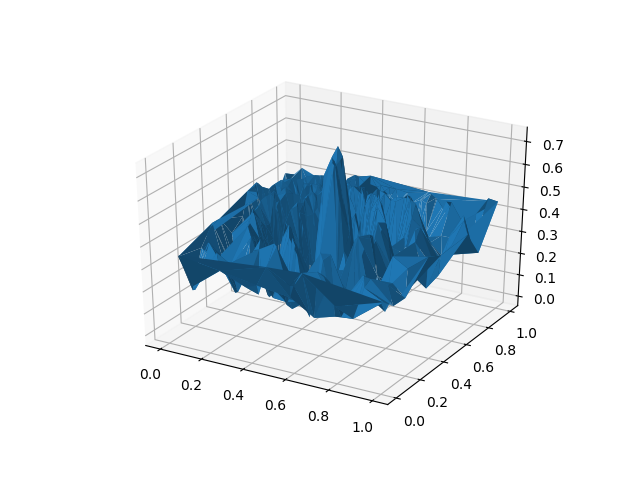

In [59]:
y_pred = sess.run(h, feed_dict={x: X_l})
y_pred = y_pred.reshape(-1)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(X_l[:,0], X_l[:,1], y_pred)

<IPython.core.display.Javascript object>


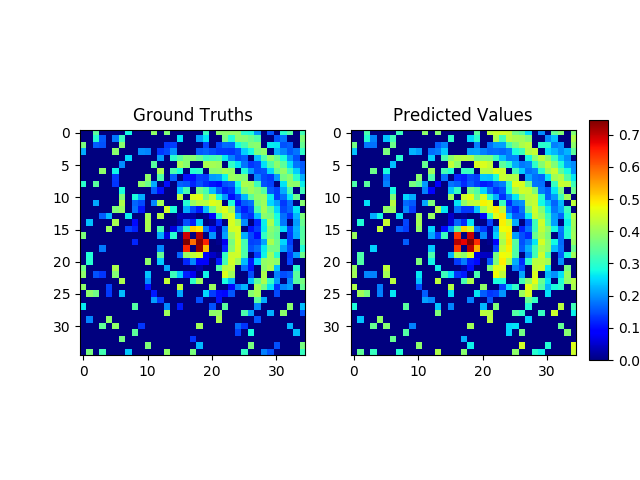

In [60]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
p0 = ax0.imshow(pts2box(X_l, sinc(X_l), 35), cmap='jet')

p1 = ax1.imshow(pts2box(X_l, y_pred, 35), cmap='jet')
cbar_ax = fig.add_axes([0.92, 0.25, 0.03, 0.50])
fig.colorbar(p1, cax=cbar_ax)

ax0.set_title('Ground Truths')
ax1.set_title('Predicted Values')

<IPython.core.display.Javascript object>


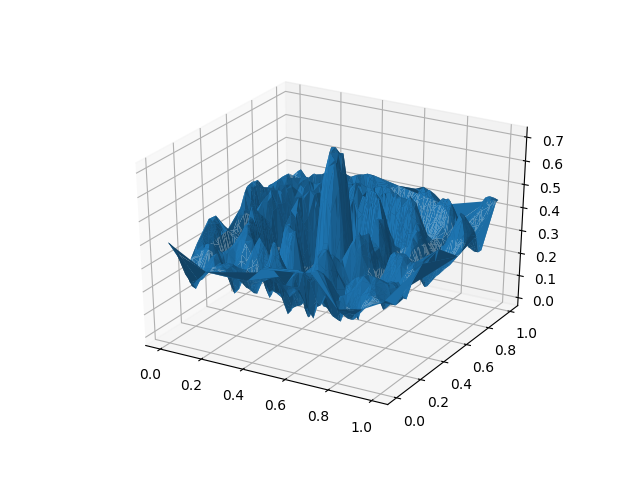

In [62]:
y_pred = sess.run(h, feed_dict={x: X_u})
y_pred = y_pred.reshape(-1)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_trisurf(X_u[:,0], X_u[:,1], y_pred)

<IPython.core.display.Javascript object>


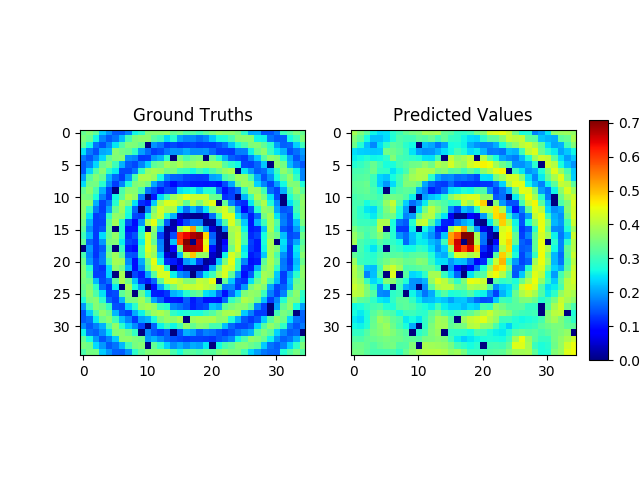

In [63]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
p0 = ax0.imshow(pts2box(X_u, sinc(X_u), 35), cmap='jet')
p1 = ax1.imshow(pts2box(X_u, y_pred, 35), cmap='jet')
cbar_ax = fig.add_axes([0.92, 0.25, 0.03, 0.50])
fig.colorbar(p1, cax=cbar_ax)

ax0.set_title('Ground Truths')
ax1.set_title('Predicted Values')